In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

nltk.download('stopwords')
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load the dataset
df = pd.read_csv("/kaggle/input/russian-tweets-preprocessed/90000_preprocess.csv", encoding='utf-8')
df.head()

,tweet_id,label,tweet_text,preprocess
0,50531.0,2,Семья с риском сокращения Covid-19.И я (и друг...,семья риск сокращение covid работник супермарк...
1,50101.0,0,['Некоторые британские # Panic кажется Покупка...,некоторый британский panic казаться покупка эт...
2,84380.0,1,['Company genomics 23andme # хочет добывать св...,company genomics andme хотеть добывать свой да...
3,70561.0,2,Компания Gilead подала в FDA запрос на отмену ...,компания gilead подать fda запрос отмена присв...
4,53293.0,2,"Калифорния запускает новый всеобъемлющий, удоб...",калифорния запускать новый всеобъемлющий удобн...


In [ ]:
# Define function for preprocessing and cleaning the text
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'#\S+', '', text) # remove hashtags
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub(r'\d+', '', text) # remove digits
    text = text.strip() # remove trailing and leading spaces
    text = " ".join([word for word in word_tokenize(text) 
      if word not in stopwords.words('russian')]) # remove stop words
    return text

In [ ]:
!pip install -U spacy>=3.0
!python -m spacy download ru_core_news_md

In [ ]:
import ru_core_news_md
import spacy

nlp = ru_core_news_md.load()

def get_lemma(text):
  document = nlp(text)
  tokens = []
  for token in document:
      tokens.append(token.lemma_.lower())
  return tokens

In [ ]:
def get_lemma(text):
  document = nlp(text)
  tokens = []
  for token in document:
      tokens.append(token.lemma_.lower())
  return tokens

In [ ]:
# Preprocess and clean the text data
df['clean_text'] = df['tweet_text'].apply(clean_text)

In [ ]:
# Lemmatization
df['preprocess'] = df['tweet_text'].apply(get_lemma)
df['preprocess'] = df['lemmatized_text'].astype(str).values

In [ ]:
df.to_csv("./drive/MyDrive/55000_preprocessed_dataset.csv", encoding='utf-8', index=False)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocess'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Load the transformer and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

# Set the model to not be trainable
transformer_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
# Encode the text using the tokenizer
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    padding='max_length',
    max_length=400,
    truncation='longest_first',
    return_tensors='tf'
)

X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    padding='max_length',
    max_length=400,
    truncation='longest_first',
    return_tensors='tf'
)

In [ ]:
# Convert the encoded text to tensor
X_train_tensor = {key: tf.convert_to_tensor(X_train_encoded[key]) for key in X_train_encoded.keys()}
X_test_tensor = {key: tf.convert_to_tensor(X_test_encoded[key]) for key in X_test_encoded.keys()}

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense
from tensorflow.keras.models import Model

In [ ]:
# Define the model architecture
input_ids = Input(shape=(400,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(400,), dtype=tf.int32, name='attention_mask')

sequence_output = transformer_model(input_ids, attention_mask)[0]
gru_output1 = Bidirectional(GRU(400))(sequence_output)
dense_output1 = Dense(400, activation='relu')(gru_output1)
output = Dense(3, activation='softmax')(dense_output1)

model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
# Compile the model
optimizer = Adam(learning_rate=0.0005)
loss = 'categorical_crossentropy'
metrics=[
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision'),
    tfa.metrics.F1Score(name='f1_score', num_classes=3)
]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Train the model
freeze_history = model.fit(
    X_train_tensor,
    tf.keras.utils.to_categorical(y_train, 3),
    epochs=10,
    batch_size=96,
    validation_data=(X_test_tensor, tf.keras.utils.to_categorical(y_test, 3))
)

Epoch 1/10
752/752 [==============================] - 1767s 2s/step - loss: 0.9244 - cat_accuracy: 0.5590 - recall: 0.3972 - precision: 0.6295 - f1_score: 0.5579 - val_loss: 0.8418 - val_cat_accuracy: 0.6227 - val_recall: 0.5327 - val_precision: 0.6736 - val_f1_score: 0.6185
Epoch 2/10
752/752 [==============================] - 1719s 2s/step - loss: 0.8188 - cat_accuracy: 0.6340 - recall: 0.5252 - precision: 0.6956 - f1_score: 0.6328 - val_loss: 0.7980 - val_cat_accuracy: 0.6544 - val_recall: 0.5930 - val_precision: 0.6966 - val_f1_score: 0.6508
Epoch 3/10
752/752 [==============================] - 1744s 2s/step - loss: 0.7656 - cat_accuracy: 0.6644 - recall: 0.5729 - precision: 0.7204 - f1_score: 0.6635 - val_loss: 0.7553 - val_cat_accuracy: 0.6761 - val_recall: 0.6179 - val_precision: 0.7160 - val_f1_score: 0.6750
Epoch 4/10
752/752 [==============================] - 1743s 2s/step - loss: 0.7148 - cat_accuracy: 0.6938 - recall: 0.6198 - precision: 0.7449 - f1_score: 0.6928 - val_loss

In [ ]:
import matplotlib.pyplot as plt

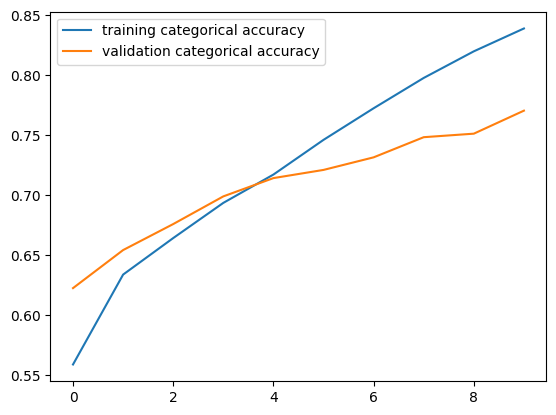

In [ ]:
plt.plot(freeze_history.history["cat_accuracy"], label="training categorical accuracy")
plt.plot(freeze_history.history["val_cat_accuracy"], label="validation categorical accuracy")
plt.legend()
plt.show()

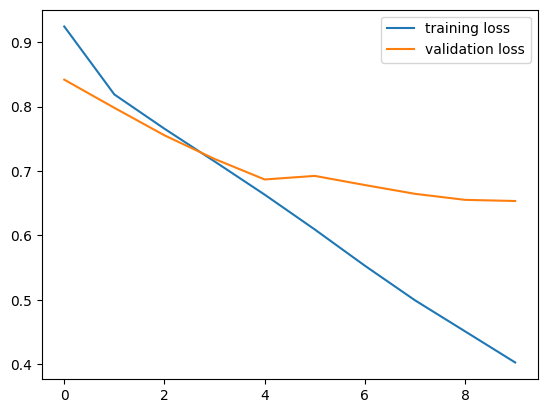

In [ ]:
plt.plot(freeze_history.history["loss"], label="training loss")
plt.plot(freeze_history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

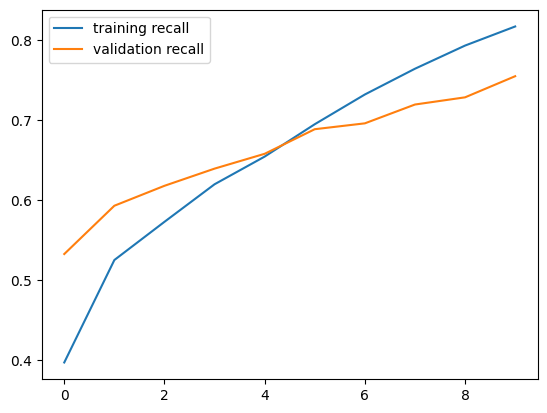

In [ ]:
plt.plot(freeze_history.history["recall"], label="training recall")
plt.plot(freeze_history.history["val_recall"], label="validation recall")
plt.legend()
plt.show()

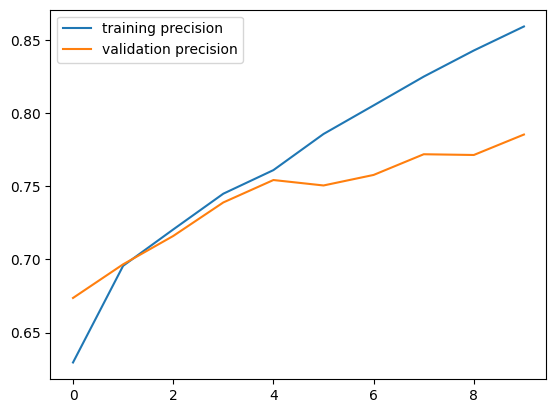

In [ ]:
plt.plot(freeze_history.history["precision"], label="training precision")
plt.plot(freeze_history.history["val_precision"], label="validation precision")
plt.legend()
plt.show()